# Morphology prediction using GO terms and abundance

This version uses Mark's U2OS abundance table

In [1]:
import pandas as pd

gene_labels = pd.read_csv('../data/cpg0016/version_2023-06-14/gene_labels.csv')

In [2]:
gene_labels

,Metadata_Symbol,Metadata_NCBI_Gene_ID,Indeterminate,Negative,Positive,gene_label
0,A2M,2,1,1,3,Positive
1,A3GALT2,127550,1,0,4,Positive
2,A4GALT,53947,0,0,5,Positive
3,A4GNT,51146,3,0,3,Indeterminate
4,AACS,65985,1,0,4,Positive
...,...,...,...,...,...,...
7970,ZSCAN32,54925,4,0,1,Indeterminate
7971,ZSCAN4,201516,0,0,3,Positive
7972,ZSCAN5A,79149,0,0,5,Positive
7973,ZSCAN9,7746,0,0,5,Positive


In [3]:
uniprot_idmapping = pd.read_excel('../data/GO/HUMAN_9606_idmapping.xlsx', dtype='str')

In [4]:
ncbi_col = 'GeneID (EntrezGene)'
go_col = 'Unnamed: 6'

In [5]:
# Get definitivey labeled subset of morphology data
definite_gene_labels = gene_labels[gene_labels.gene_label.isin(['Positive', 'Negative'])]

In [6]:
# Expand lists from ID mapping table
gene_id_lists = uniprot_idmapping[ncbi_col].str.split('; ')
go_lists = uniprot_idmapping[go_col].str.split('; ')

In [7]:
go_long_df = (
    pd.DataFrame({'Gene_ID': gene_id_lists, 'GO': go_lists})
    .explode('Gene_ID')
    .explode('GO')
    .dropna()
)

# Filter down GO lists

go_long_df = go_long_df[
    go_long_df.Gene_ID.astype('int64').isin(definite_gene_labels['Metadata_NCBI_Gene_ID'])
].drop_duplicates()

In [8]:
# Make matrix

go_df = go_long_df.pivot_table(
    index='Gene_ID',
    columns='GO',
    aggfunc=lambda _: 1,
    fill_value=0
)
go_df

GO,GO:0000002,GO:0000003,GO:0000009,GO:0000010,GO:0000012,GO:0000014,GO:0000015,GO:0000016,GO:0000017,GO:0000018,...,GO:2001287,GO:2001288,GO:2001294,GO:2001295,GO:2001301,GO:2001302,GO:2001303,GO:2001304,GO:2001306,GO:2001311
Gene_ID,,,,,,,,,,,,,,,,,,,,,
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grab abundance features

In [9]:
cell_line_df = pd.read_table('../../../data/cellular-localization/gene_abundances_U2OS.tsv')
undetected_df = pd.read_table('../../../data/cellular-localization/undetected_genes_U2OS.tsv')
abundance_df = cell_line_df[['Gene', 'RNA line ab']]
abundance_df.loc[:, 'Protein present'] = 1
abundance_df.loc[abundance_df['Gene'].isin(undetected_df['Gene']), 'Protein present'] = 0
# Collapse any duplicate Gene entries
abundance_df = abundance_df.groupby('Gene').max()
abundance_df

/tmp/ipykernel_304807/3403128214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abundance_df.loc[:, 'Protein present'] = 1


,RNA line ab,Protein present
Gene,,
A1BG,0.3,1
A1CF,0.0,0
A2M,4.3,1
A2ML1,0.1,1
A3GALT2,0.0,0
...,...,...
ZYG11A,0.1,1
ZYG11B,7.4,1
ZYX,60.6,1


Join abundance to labels for consistent indexing

In [10]:
ab_labels_df = abundance_df.merge(
    definite_gene_labels[['Metadata_NCBI_Gene_ID', 'Metadata_Symbol', 'gene_label']],
    how='inner',
    left_index=True,
    right_on='Metadata_Symbol'
).set_index('Metadata_NCBI_Gene_ID')
ab_labels_df

,RNA line ab,Protein present,Metadata_Symbol,gene_label
Metadata_NCBI_Gene_ID,,,,
2,4.3,1,A2M,Positive
127550,0.0,0,A3GALT2,Positive
53947,2.5,1,A4GALT,Positive
65985,18.6,1,AACS,Positive
13,1.2,1,AADAC,Positive
...,...,...,...,...
64288,74.4,1,ZSCAN31,Positive
201516,0.2,1,ZSCAN4,Positive
79149,8.9,1,ZSCAN5A,Positive


Construct vectors for ML

In [11]:
y = ab_labels_df['gene_label'].map({'Positive': 0, 'Negative': 1})
y

Metadata_NCBI_Gene_ID
2         0
127550    0
53947     0
65985     0
13        0
         ..
64288     0
201516    0
79149     0
7746      0
151112    0
Name: gene_label, Length: 6868, dtype: int64

In [12]:
ab_x = ab_labels_df[['RNA line ab', 'Protein present']]

In [13]:
go_df.index = go_df.index.astype('int64')

In [14]:
go_x = go_df.sort_index()

In [15]:
y.shape, go_x.shape, ab_x.shape

((6868,), (6968, 15739), (6868, 2))

ML Run

/ua/yuriy/mambaforge/envs/jupyterlab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ua/yuriy/mambaforge/envs/jupyterlab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

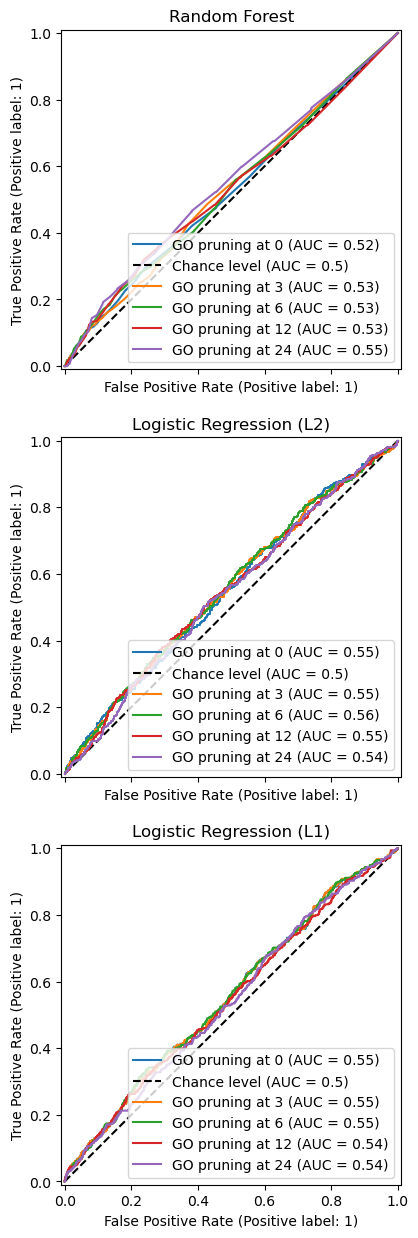

In [16]:
# Defining inputs for machine learning models
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize, LabelEncoder
from matplotlib.pyplot import subplots

models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression (L2)': LogisticRegression(penalty='l2'),
    'Logistic Regression (L1)': LogisticRegression(penalty='l1', solver='liblinear')
}

cv = StratifiedKFold(n_splits=10, random_state=20240131, shuffle=True)

fig, ax = subplots(nrows=len(models), ncols=1, sharex=True, sharey=True, squeeze=False, figsize=(5,15))

col = 0
first = True
for pruning in [0,3,6,12,24]:

    go_x_pruned = go_x.loc[:, go_x.sum(axis='index') >= pruning]
    x = ab_x.join(go_x_pruned, how='inner')
    y_pruned = y.filter(x.index, axis='index').sort_index()

    for row, (name, model) in enumerate(models.items()):
        probs = cross_val_predict(model, x, y_pruned, cv=cv, method='predict_proba')[:, 1]
        RocCurveDisplay.from_predictions(y_pruned, probs, name=f'GO pruning at {pruning}', plot_chance_level=first, ax=ax[row, col])
        if first:
            ax[row, col].set_title(f'{name}')

    first = False